## Classifying Audio Vs Visual labels 

In [65]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-PCA.ipynb
import mne 

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout
from mne.decoding import LinearModel
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline
import time

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.


In [95]:
path = 'E:/correct_time_epochs/'
epoch_files = os.listdir(path)
epoch_files[:5]
file = os.path.join(path, epoch_files[2])

In [96]:
# read epoch object 
epoch = mne.read_epochs(file, preload= True)

Reading E:/correct_time_epochs/20140205_1114_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1908 matching events found
Applying baseline correction (mode: mean)
1908 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [13]:
# drop bad channels 
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

In [17]:
evoked = epoch.average();

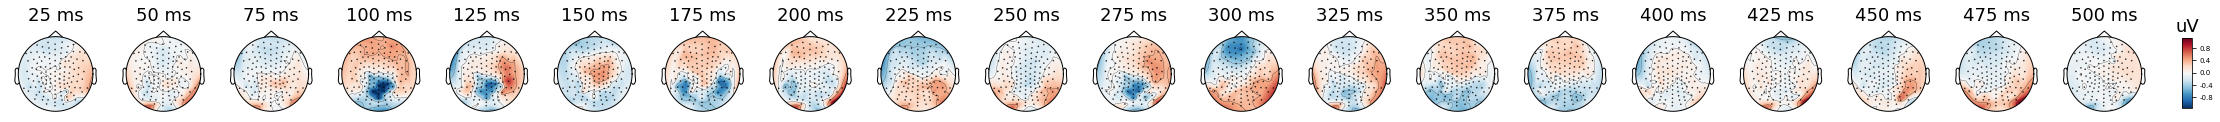

In [34]:
times = np.arange(.025,.525,.025)
plot = evoked.plot_topomap(times= times, time_unit='ms');

    using multitaper spectrum estimation with 7 DPSS windows


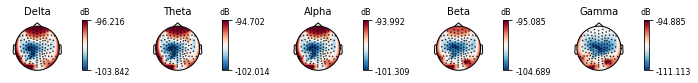

In [16]:
epoch.plot_psd_topomap();

In [69]:
def get_audio_visual_labels(epoch_object):
    events = epoch_object.events[:,-1]
    labels = []
    for event in events:
        if event < 700:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels) 

In [90]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch

In [99]:
def classify_lgr(epoch_object, do_mean_stats = False, freq_band ='None'):
    clf = make_pipeline(Vectorizer(),
                        StandardScaler(),
                        LinearModel(LogisticRegression(solver='lbfgs',max_iter=1000)))
    start_master = time.time()
    new_events = convert_epoch_events_to_stim_combinations(epoch_object= epoch_object)
    
    epoch_object.events = new_events
    labels = get_audio_visual_labels(epoch_object)
    
    start_master = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
    
    if freq_band.lower() == 'gamma':
        freq_data = get_frequency_band('Gamma', epoch_object=epoch_object)
    elif freq_band.lower() == 'alpha':
        freq_data = get_frequency_band('Alpha', epoch_object=epoch_object)
    elif freq_band.lower() == 'beta':
        freq_data = get_frequency_band('Beta', epoch_object=epoch_object)
    elif freq_band.lower() == 'theta':
        freq_data = get_frequency_band('Theta', epoch_object=epoch_object)
    elif freq_band.lower() =='none':
        freq_data = epoch.get_data()
    else:
        return "{0} is an invalid frequency band! \n Please select \
                Theta, Alpha, Beta, or Gamma".format(freq_band)
        
    
    if do_mean_stats:
        data = get_mean_band(freq_data)
        data = data.swapaxes(1,2)
    else:
        data = freq_data
    
    preds = np.empty(len(data))
    for train, test in cv.split(data, labels):
        start = time.time()
        clf.fit(data[train], labels[train])
        preds[test] = clf.predict(data[test])
        end = time.time()
        print("kfold elapsed time: {0}".format(end - start))
    end = time.time()
    print("classification elapsed time: {0}".format(end - start_master))

    start = time.time()
    target_names = ['Audio', 'Visual']
    report = classification_report(labels, preds, target_names=target_names)
    print(report)
    end = time.time()
    print("reporting elapsed time: {0}".format(end - start))
    
    return report

In [97]:
classify_lgr(epoch_object=epoch, do_mean_stats=False, freq_band='None')

kfold elapsed time: 38.832558155059814
kfold elapsed time: 43.3173246383667
kfold elapsed time: 34.14532709121704
kfold elapsed time: 36.2394859790802
kfold elapsed time: 36.67937755584717
classification elapsed time: 189.2539722919464
              precision    recall  f1-score   support

       Audio       0.64      0.62      0.63      1011
      Visual       0.59      0.61      0.60       897

   micro avg       0.62      0.62      0.62      1908
   macro avg       0.62      0.62      0.62      1908
weighted avg       0.62      0.62      0.62      1908

reporting elapsed time: 0.01994633674621582


In [108]:
epoch = mne.read_epochs(file, preload= True)

Reading E:/correct_time_epochs/20140205_1114_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1908 matching events found
Applying baseline correction (mode: mean)
1908 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [101]:
alpha_report = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=False, freq_band='Alpha')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected
filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


kfold elapsed time: 48.4377555847168
kfold elapsed time: 50.31987905502319
kfold elapsed time: 49.43351340293884
kfold elapsed time: 48.29657030105591
kfold elapsed time: 46.92910385131836
classification elapsed time: 267.1942822933197
              precision    recall  f1-score   support

       Audio       0.62      0.63      0.63      1011
      Visual       0.58      0.57      0.58       897

   micro avg       0.60      0.60      0.60      1908
   macro avg       0.60      0.60      0.60      1908
weighted avg       0.60      0.60      0.60      1908

reporting elapsed time: 0.0049860477447509766


In [102]:
alpha_report_mean_stats = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=True, freq_band='alpha')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected
filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


kfold elapsed time: 0.08489418029785156
kfold elapsed time: 0.08178162574768066
kfold elapsed time: 0.09175443649291992
kfold elapsed time: 0.09881353378295898
kfold elapsed time: 0.09870123863220215
classification elapsed time: 83.05801749229431
              precision    recall  f1-score   support

       Audio       0.60      0.60      0.60      1011
      Visual       0.55      0.55      0.55       897

   micro avg       0.58      0.58      0.58      1908
   macro avg       0.58      0.58      0.58      1908
weighted avg       0.58      0.58      0.58      1908

reporting elapsed time: 0.0029916763305664062


In [103]:
beta_report = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=False, freq_band='beta')
beta_report_mean_stats = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=True, freq_band='beta')

Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 521 samples (1.018 sec) selected
filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


kfold elapsed time: 31.495722770690918
kfold elapsed time: 30.630903720855713
kfold elapsed time: 29.480818510055542
kfold elapsed time: 30.2881338596344
kfold elapsed time: 29.673361778259277
classification elapsed time: 179.67466807365417
              precision    recall  f1-score   support

       Audio       0.59      0.60      0.60      1011
      Visual       0.54      0.54      0.54       897

   micro avg       0.57      0.57      0.57      1908
   macro avg       0.57      0.57      0.57      1908
weighted avg       0.57      0.57      0.57      1908

reporting elapsed time: 0.0029916763305664062
Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 521 samples (1.018 sec) selected
filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


kfold elapsed time: 0.07579708099365234
kfold elapsed time: 0.07779240608215332
kfold elapsed time: 0.07280516624450684
kfold elapsed time: 0.07879090309143066
kfold elapsed time: 0.09374833106994629
classification elapsed time: 87.71775031089783
              precision    recall  f1-score   support

       Audio       0.62      0.61      0.61      1011
      Visual       0.57      0.58      0.57       897

   micro avg       0.60      0.60      0.60      1908
   macro avg       0.59      0.59      0.59      1908
weighted avg       0.60      0.60      0.60      1908

reporting elapsed time: 0.002991914749145508


In [104]:
theta_report = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=False, freq_band='theta')
theta_report_mean_stats = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=True, freq_band='theta')

Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 845 samples (1.650 sec) selected
filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


kfold elapsed time: 52.88377356529236


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


kfold elapsed time: 49.80598163604736


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


kfold elapsed time: 49.989896297454834


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


kfold elapsed time: 49.31468725204468


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


kfold elapsed time: 49.20292901992798
classification elapsed time: 273.99414825439453
              precision    recall  f1-score   support

       Audio       0.63      0.61      0.62      1011
      Visual       0.57      0.60      0.59       897

   micro avg       0.60      0.60      0.60      1908
   macro avg       0.60      0.60      0.60      1908
weighted avg       0.60      0.60      0.60      1908

reporting elapsed time: 0.003988981246948242
Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 845 samples (1.650 sec) selected
filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-90-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


kfold elapsed time: 0.08975934982299805
kfold elapsed time: 0.07779455184936523
kfold elapsed time: 0.08479738235473633
kfold elapsed time: 0.0777440071105957
kfold elapsed time: 0.10372114181518555
classification elapsed time: 83.54997515678406
              precision    recall  f1-score   support

       Audio       0.57      0.58      0.58      1011
      Visual       0.52      0.51      0.51       897

   micro avg       0.55      0.55      0.55      1908
   macro avg       0.54      0.54      0.54      1908
weighted avg       0.55      0.55      0.55      1908

reporting elapsed time: 0.003989219665527344


In [105]:
gamma_report = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=False, freq_band='gamma')
gamma_report_mean_stats = classify_lgr(epoch_object=epoch.copy(), do_mean_stats=True, freq_band='gamma')

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 225 samples (0.439 sec) selected
kfold elapsed time: 28.397111177444458
kfold elapsed time: 26.011359453201294
kfold elapsed time: 25.62969422340393
kfold elapsed time: 26.983691692352295
kfold elapsed time: 25.814116716384888
classification elapsed time: 152.98170137405396
              precision    recall  f1-score   support

       Audio       0.55      0.56      0.56      1011
      Visual       0.49      0.49      0.49       897

   micro avg       0.53      0.53      0.53      1908
   macro avg       0.52      0.52      0.52      1908
weighted avg       0.52      0.53      0.52      1908

reporting elapsed time: 0.0029916763305664062
Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 225 samples (0.439 sec) selected
kfold elapsed time: 0.07781195640563965
kfo

In [ ]:
report_mean_stats = classify_lgr(epoch.copy(), do_mean_stats=True)